In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.formula.api as smf
matplotlib.style.use('ggplot')
%matplotlib inline

# Load the data on various variables
population = pd.read_excel('data/zh-population.xlsx')
population.rename(columns={'BFS_NR': 'municipality', 'GEBIET_NAME': 'municipality_name', 'INDIKATOR_JAHR': 'year'}, inplace=True)
income_and_wealth = pd.read_excel('data/zh-income-wealth.xlsx')
income_and_wealth.rename(columns={'BFS_NR': 'municipality', 'GEBIET_NAME': 'municipality_name', 'INDIKATOR_JAHR': 'year'}, inplace=True)

# helper function
def extract_group(df_grouped, group_id, column_name):
    frame = df_grouped.get_group(group_id).rename(columns={'INDIKATOR_VALUE' : column_name})
    return frame[['municipality', 'year', 'municipality_name', column_name]]

# Pick out the series we are interested in and discard columns we do not want
population_grouped = population.groupby('INDIKATOR_ID')
pop_20_to_39 = extract_group(population_grouped, 85, 'pct20_39')
pop_40_to_64 = extract_group(population_grouped, 87, 'pct40_64')
pop_65_to_79 = extract_group(population_grouped, 89, 'pct65_79')
pop_80_plus = extract_group(population_grouped, 91, 'pct80plus')
female = extract_group(population_grouped, 206, 'pctfemale')
foreign = extract_group(population_grouped, 205, 'pctforeign')
demographics = pop_20_to_39.merge(pop_40_to_64).merge(pop_65_to_79).merge(pop_80_plus).merge(female).merge(foreign)

income_and_wealth_grouped = income_and_wealth.groupby('INDIKATOR_ID')
median_income = extract_group(income_and_wealth_grouped, 316, 'income')
median_wealth = extract_group(income_and_wealth_grouped, 320, 'wealth')
median_income_and_wealth = median_income.merge(median_wealth, on=['municipality', 'year'], how="left")
# Drop the redundant columns
median_income_and_wealth = median_income_and_wealth[['municipality', 'year', 'income', 'wealth']]

# Load the data on voting
votes = pd.read_csv('data/2015-06-elections-partystrengths/analysis/output/partystrengths.csv')
parties = pd.read_csv('data/2015-06-elections-partystrengths/analysis/output/parties.csv')
parties.rename(columns={'ID': 'party', 'Abbr_D': 'party_name'}, inplace=True)
parties = parties[['party', 'party_name']]

# Create a frame that merges demographic, income, and voting data
df = demographics.merge(median_income_and_wealth,
        on=['municipality', 'year'], how='inner').merge(votes,
        on=['municipality', 'year'], how='inner').merge(parties,
        on='party', how='left')

In [2]:
df.head()

,municipality,year,municipality_name,pct20_39,pct40_64,pct65_79,pct80plus,pctfemale,pctforeign,income,wealth,party,support,party_name
0,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,1,0.247092,FDP
1,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,2,0.025894,CVP
2,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,3,0.252853,SP
3,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,4,0.296906,SVP
4,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,7,0.014428,EVP


In [3]:
# Compute z-scores for income and party support for easier comparibility accross times
zscore = lambda x: (x - x.mean()) / x.std()
df['z_income'] = pd.Series(df.groupby(['year'])['income'].transform(zscore), index=df.index)
df['z_wealth'] = pd.Series(df.groupby(['year'])['wealth'].transform(zscore), index=df.index)
df['z_support'] = pd.Series(df.groupby(['year', 'party'])['support'].transform(zscore), index=df.index)

In [4]:
df.head()

,municipality,year,municipality_name,pct20_39,pct40_64,pct65_79,pct80plus,pctfemale,pctforeign,income,wealth,party,support,party_name,z_income,z_wealth,z_support
0,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,1,0.247092,FDP,0.31947,NaN,1.245728
1,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,2,0.025894,CVP,0.31947,NaN,-0.641184
2,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,3,0.252853,SP,0.31947,NaN,1.033298
3,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,4,0.296906,SVP,0.31947,NaN,-1.285255
4,1,1999,Aeugst a.A.,24.4,39.8,8.5,1.7,49.8,4.8,47700,NaN,7,0.014428,EVP,0.31947,NaN,-1.155562


In [5]:
def plot_relationship(party, variable, ax):
    # Get the data for the party/year
    data = df.groupby('party_name').get_group(party)
    # Filter out NaNs
    data = data[np.isfinite(data[variable])]
    # Create a model
    formula = 'z_support ~ {}'.format(variable)
    lm = smf.ols(formula=formula, data=data).fit()
    rsquared = lm.rsquared
    preds_input = pd.DataFrame({variable: [data[variable].min(), data[variable].max()]})
    preds = lm.predict(preds_input)
    # Plot the data
    data.plot(x=variable, y='z_support', kind='scatter', ax=ax)
    # Plot the model
    ax.plot(preds_input, preds, c='red', linewidth=2)
    ax.text(1.0, 0.05,'R^2 = {:.2f}'.format(rsquared), horizontalalignment='right',
      verticalalignment='center', color='red',
      transform=ax.transAxes)
    
def plot_monetary_relationships(party):
    fig, axs = plt.subplots(1,2, sharey=True)
    plot_relationship(party, 'z_income', axs[0])
    plot_relationship(party, 'z_wealth', axs[1])
    fig.suptitle(party + ' support by income and wealth', fontsize=16)
    
def plot_demographic_relationships(party):
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(10, 4))
    plot_relationship(party, 'pct20_39', axs[0])
    plot_relationship(party, 'pct40_64', axs[1])
    plot_relationship(party, 'pct65_79', axs[2])
    fig.suptitle(party + ' support by age', fontsize=16)

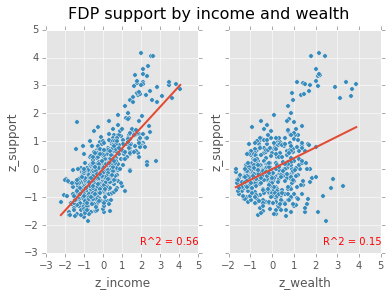

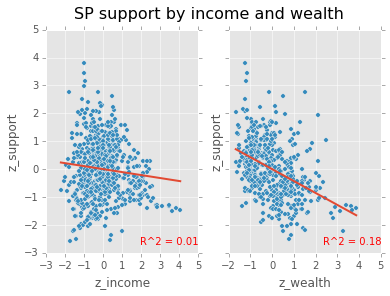

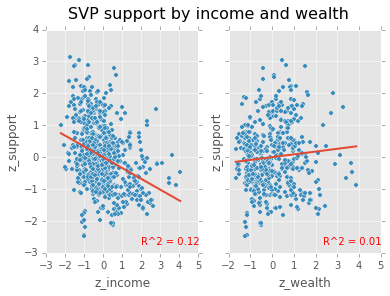

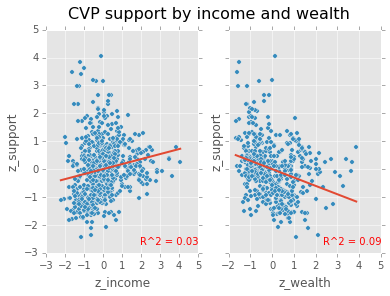

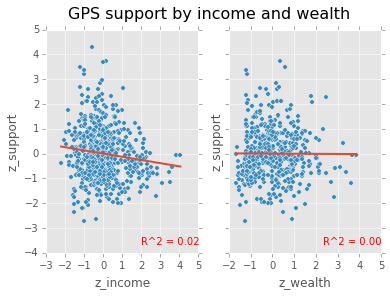

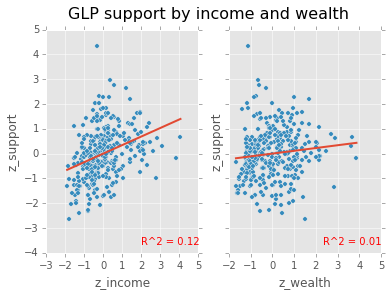

In [6]:
plot_monetary_relationships('FDP')
plot_monetary_relationships('SP')
plot_monetary_relationships('SVP')
plot_monetary_relationships('CVP')
plot_monetary_relationships('GPS')
plot_monetary_relationships('GLP')
# plot_monetary_relationships('BDP')
# plot_monetary_relationships('EVP')

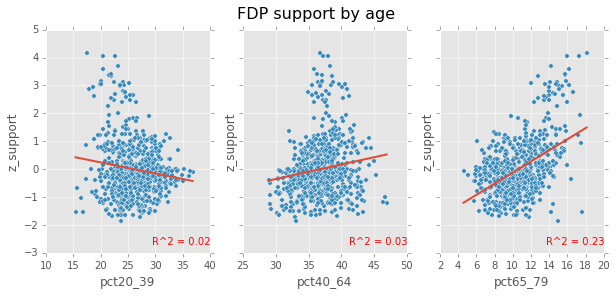

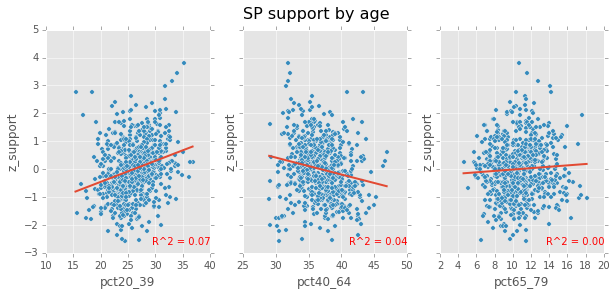

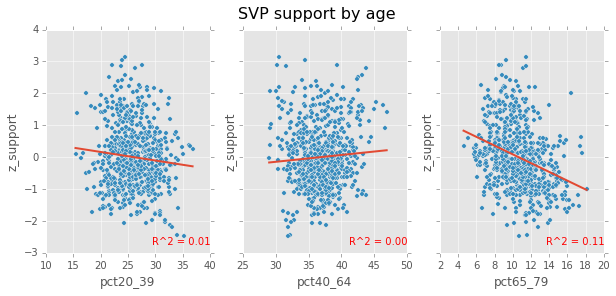

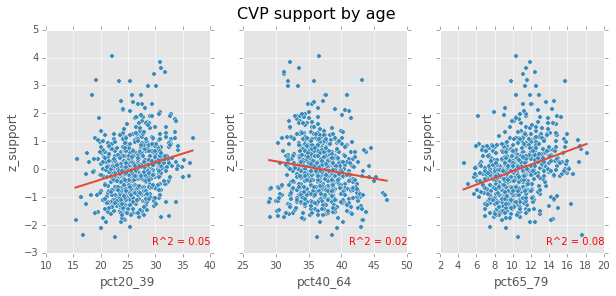

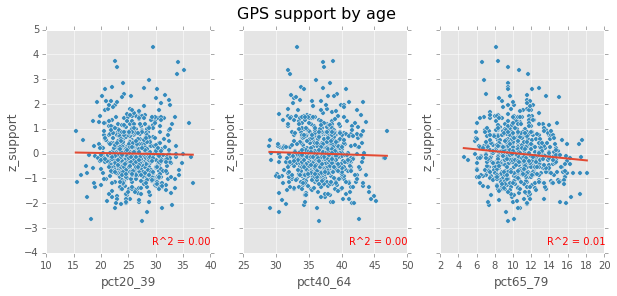

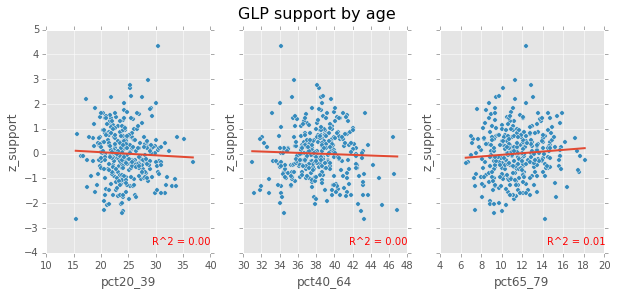

In [7]:
plot_demographic_relationships('FDP')
plot_demographic_relationships('SP')
plot_demographic_relationships('SVP')
plot_demographic_relationships('CVP')
plot_demographic_relationships('GPS')
plot_demographic_relationships('GLP')
# plot_demographic_relationships('BDP')
# plot_demographic_relationships('EVP')